# CNN cross-validation demo (3 days -> 1 day)

This notebook demonstrates: 
- loading preprocessed windows from `DataProcessor` (3 days input -> 1 day output),
- selecting the 4 sub-metering channels as multi-channel input,
- building time-series folds with `TimeSeriesSplit`,
- running cross-validation training using `cnn_model_yin.CNN` and `cross_validate`,
- plotting per-fold train/val loss and evaluating on the test set.

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from cnn_model_yin import CNN, cross_validate, train
import torch
import torch.nn as nn
import random
import os, sys

# load data through the data preprocessor
sys.path.append(os.path.abspath('..'))  # add parent directory to sys.path
from data_cleanup import DataProcessor

# Reproducibility (best-effort)
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

## Data Preprocessing

In [3]:
# Instantiate DataProcessor for 3 days -> 1 day
INPUT_STEPS = 24 * 3  # 72 hours
OUTPUT_STEPS = 24 # 24 hours
processor = DataProcessor(input_steps=INPUT_STEPS, output_steps=OUTPUT_STEPS,local_raw_path='../raw-consumption-data.zip')

# This will fetch, clean, resample and window the data (may take a moment)
(X_train, y_train), (X_val, y_val), (X_test, y_test) = processor.load_and_process_data()

print('Shapes:')
print('X_train', X_train.shape, 'y_train', y_train.shape)
print('X_val', X_val.shape, 'y_val', y_val.shape)
print('X_test', X_test.shape, 'y_test', y_test.shape)

Step 1/5: Fetching, cleaning, and engineering features...


e:\ywc_college\junior1\notebook\Machine Learning\pj\ECS171G13\data_cleanup.py:132: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
e:\ywc_college\junior1\notebook\Machine Learning\pj\ECS171G13\data_cleanup.py:172: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H').agg(agg_dict)


Step 2/5: Resampling data to hourly and setting 'Global_active_power' as target...
Step 3/5: Splitting data and applying scaler...
Step 4/5: Creating time-series windows...
Step 5/5: Data processing complete.
Shapes:
X_train (25832, 72, 8) y_train (25832, 24)
X_val (3529, 72, 8) y_val (3529, 24)
X_test (4943, 72, 8) y_test (4943, 24)
Step 3/5: Splitting data and applying scaler...
Step 4/5: Creating time-series windows...
Step 5/5: Data processing complete.
Shapes:
X_train (25832, 72, 8) y_train (25832, 24)
X_val (3529, 72, 8) y_val (3529, 24)
X_test (4943, 72, 8) y_test (4943, 24)


e:\ywc_college\junior1\notebook\Machine Learning\pj\ECS171G13\data_cleanup.py:173: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_hourly = df_hourly.fillna(method='ffill')


In [4]:
# Select the 4 sub-metering channels as input channels
# Based on data_cleanup.py ordering, expected columns after reorder are:
# [Global_active_power, Global_reactive_power, Voltage, Global_intensity,
#  Sub_metering_1, Sub_metering_2, Sub_metering_3, Sub_metering_rest]
# So sub-metering channel indices (0-based) are 4..7
channel_indices = [4,5,6,7]
n_features = X_train.shape[2]
assert max(channel_indices) < n_features, 'Channel indices out of range for X_train features'

X_train_ch = X_train[:, :, channel_indices]  # shape (n_samples, time, 4)
X_val_ch   = X_val[:, :, channel_indices]
X_test_ch  = X_test[:, :, channel_indices]

print('Selected channel shapes:')
print('X_train_ch', X_train_ch.shape, 'y_train', y_train.shape)

Selected channel shapes:
X_train_ch (25832, 72, 4) y_train (25832, 24)


In [5]:
# Create TimeSeriesSplit folds from the training windows (time-aware)
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
folds = []
for train_idx, val_idx in tscv.split(X_train_ch):
    Xtr = X_train_ch[train_idx]
    ytr = y_train[train_idx]
    Xval = X_train_ch[val_idx]
    yval = y_train[val_idx]
    folds.append(((Xtr, ytr), (Xval, yval)))

print(f'Constructed {len(folds)} folds. Example fold shapes:')
print('fold0 train X', folds[0][0][0].shape, 'y', folds[0][0][1].shape, 'val X', folds[0][1][0].shape)

Constructed 5 folds. Example fold shapes:
fold0 train X (4307, 72, 4) y (4307, 24) val X (4305, 72, 4)


## Model Training

In [6]:
# Define model factory (callable returning a fresh model)
def make_model():
    return CNN(in_channels=4, input_length=INPUT_STEPS, output_steps=OUTPUT_STEPS)

### A demo for cross-validation training

In [7]:
# Run cross-validation quickly (small epochs for demo) WITH checkpoint saving
histories, val_losses, best_cv_checkpoint_path = cross_validate(
    make_model,
    folds,
    device=None,
    epochs=3,
    batch_size=32,
    lr=1e-3,
    verbose=True,
    checkpoint_dir='checkpoint/cv_demo',
    save_best_only=True
)
print('Per-fold final val losses:', val_losses)
print('Best CV checkpoint path:', best_cv_checkpoint_path)
print('Best per-fold checkpoint directories saved under: checkpoint/cv_demo/')

Starting fold 1/5: train (4307, 72, 4) | val (4305, 72, 4)
Epoch 1/3 - train_loss: 0.028640 - val_loss: 0.020585
Epoch 1/3 - train_loss: 0.028640 - val_loss: 0.020585
Epoch 2/3 - train_loss: 0.026916 - val_loss: 0.019387
Epoch 2/3 - train_loss: 0.026916 - val_loss: 0.019387
Epoch 3/3 - train_loss: 0.024278 - val_loss: 0.016421
Starting fold 2/5: train (8612, 72, 4) | val (4305, 72, 4)
Epoch 3/3 - train_loss: 0.024278 - val_loss: 0.016421
Starting fold 2/5: train (8612, 72, 4) | val (4305, 72, 4)
Epoch 1/3 - train_loss: 0.024025 - val_loss: 0.021263
Epoch 1/3 - train_loss: 0.024025 - val_loss: 0.021263
Epoch 2/3 - train_loss: 0.019081 - val_loss: 0.017467
Epoch 2/3 - train_loss: 0.019081 - val_loss: 0.017467
Epoch 3/3 - train_loss: 0.017109 - val_loss: 0.016957
Starting fold 3/5: train (12917, 72, 4) | val (4305, 72, 4)
Epoch 3/3 - train_loss: 0.017109 - val_loss: 0.016957
Starting fold 3/5: train (12917, 72, 4) | val (4305, 72, 4)
Epoch 1/3 - train_loss: 0.021404 - val_loss: 0.013400
E

### Plain training & testing

In [8]:
# Final full training on all training windows + validation, save best checkpoint
import os
os.makedirs('checkpoint/run1', exist_ok=True)
final_hist = train(
    make_model(),
    X_train_ch,
    y_train,
    X_val=X_val_ch,
    y_val=y_val,
    device=None,
    epochs=10,
    batch_size=32,
    lr=1e-3,
    verbose=True,
    checkpoint_dir='checkpoint/run1',
    checkpoint_prefix='final',
    save_best_only=True
)
print('Final training best val loss:', final_hist['best_val_loss'])
print('Best checkpoint path:', final_hist['checkpoint_path'])

Epoch 1/10 - train_loss: 0.016528 - val_loss: 0.013187
Epoch 2/10 - train_loss: 0.013821 - val_loss: 0.012699
Epoch 2/10 - train_loss: 0.013821 - val_loss: 0.012699
Epoch 3/10 - train_loss: 0.013184 - val_loss: 0.012580
Epoch 3/10 - train_loss: 0.013184 - val_loss: 0.012580
Epoch 4/10 - train_loss: 0.012850 - val_loss: 0.012501
Epoch 4/10 - train_loss: 0.012850 - val_loss: 0.012501
Epoch 5/10 - train_loss: 0.012590 - val_loss: 0.012503
Epoch 5/10 - train_loss: 0.012590 - val_loss: 0.012503
Epoch 6/10 - train_loss: 0.012393 - val_loss: 0.012455
Epoch 6/10 - train_loss: 0.012393 - val_loss: 0.012455
Epoch 7/10 - train_loss: 0.012065 - val_loss: 0.012507
Epoch 7/10 - train_loss: 0.012065 - val_loss: 0.012507
Epoch 8/10 - train_loss: 0.011841 - val_loss: 0.012562
Epoch 8/10 - train_loss: 0.011841 - val_loss: 0.012562
Epoch 9/10 - train_loss: 0.011580 - val_loss: 0.012655
Epoch 9/10 - train_loss: 0.011580 - val_loss: 0.012655
Epoch 10/10 - train_loss: 0.011332 - val_loss: 0.012805
Final tra

In [9]:
# Load best model for test evaluation
best_model = make_model()
if final_hist['checkpoint_path']:
    ckpt = torch.load(final_hist['checkpoint_path'], map_location='cpu')
    best_model.load_state_dict(ckpt['model_state_dict'])

# Evaluate on test set (ensure tensor shapes and device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = best_model.to(device)
best_model.eval()

with torch.no_grad():
    Xt = torch.tensor(X_test_ch, dtype=torch.float32).to(device)
    if Xt.ndim == 3 and Xt.shape[2] == 4 and Xt.shape[1] != 4:
        Xt = Xt.permute(0, 2, 1)
    preds = best_model(Xt)
    yt = torch.tensor(y_test, dtype=torch.float32).to(device)
    preds_np = preds.cpu().numpy()
    yt_np = yt.cpu().numpy()

# Inverse-transform each horizon step separately back to original units using the processor's scaler
preds_un = np.zeros_like(preds_np)
yt_un = np.zeros_like(yt_np)
for t in range(preds_np.shape[1]):
    try:
        preds_un[:, t] = processor.inverse_transform_predictions(preds_np[:, t])
        yt_un[:, t] = processor.inverse_transform_predictions(yt_np[:, t])
    except Exception as e:
        print('Warning: inverse transform failed for horizon step', t, '-> plotting scaled values. Error:', e)
        preds_un[:, t] = preds_np[:, t]
        yt_un[:, t] = yt_np[:, t]

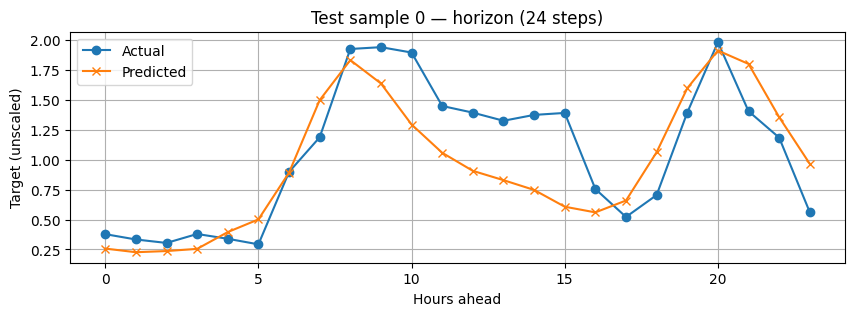

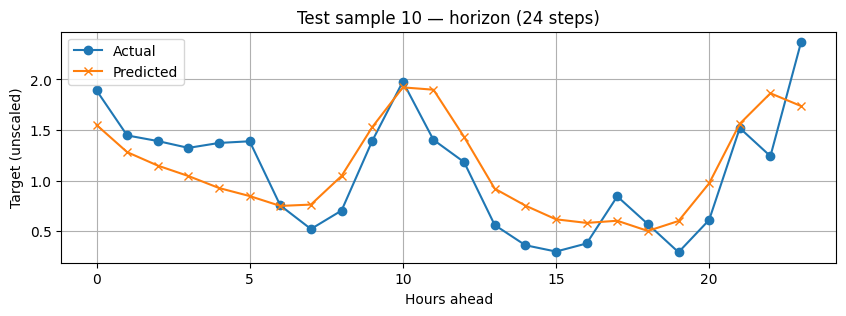

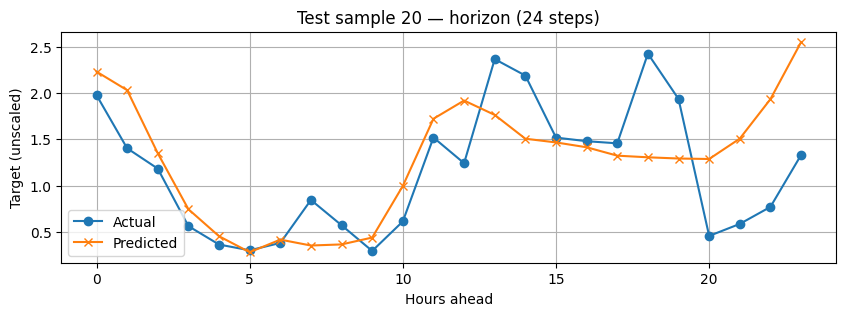

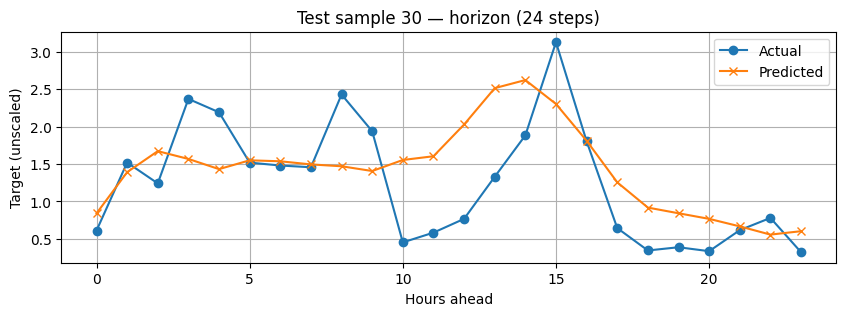

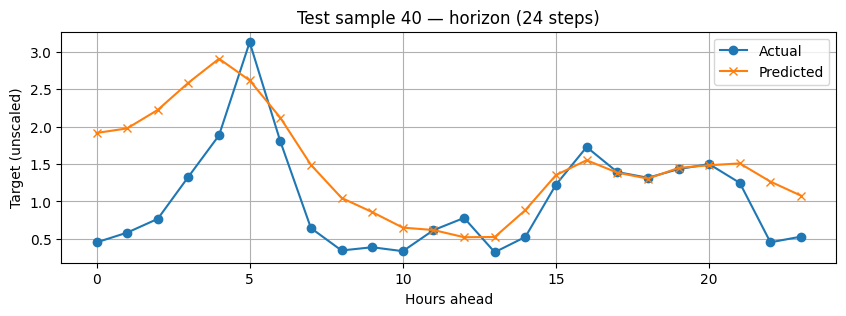

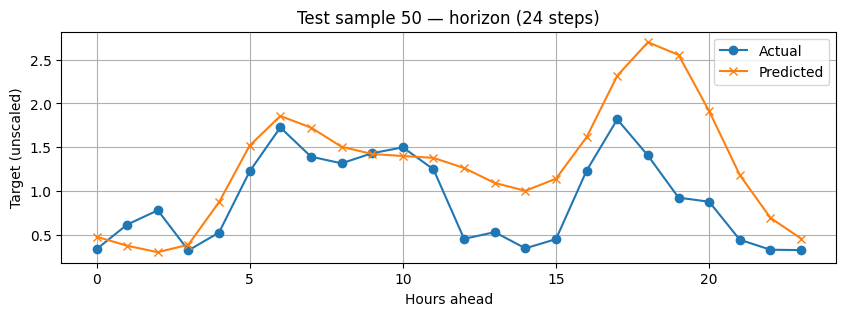

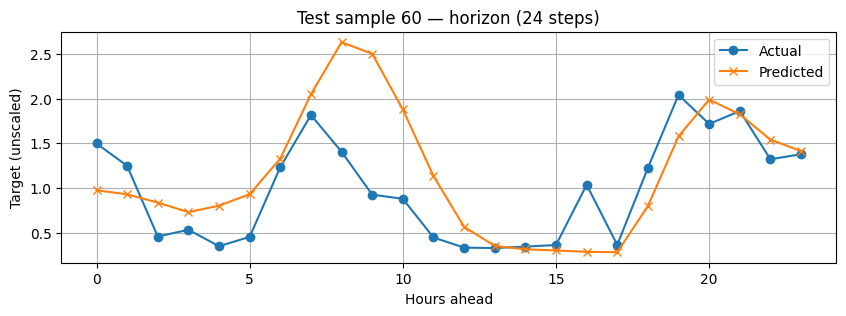

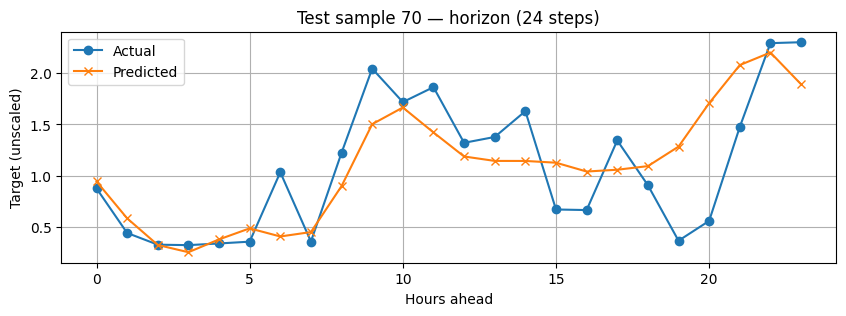

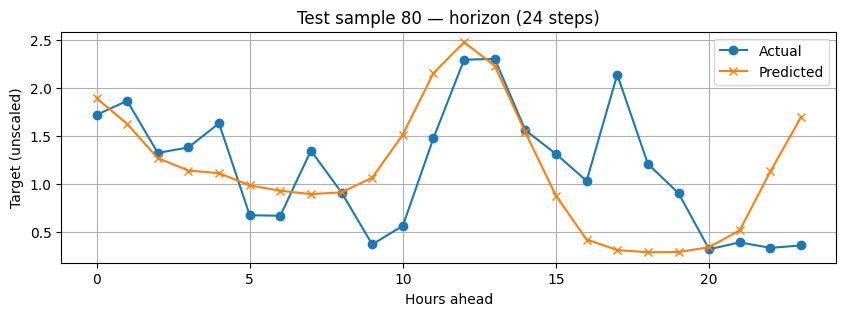

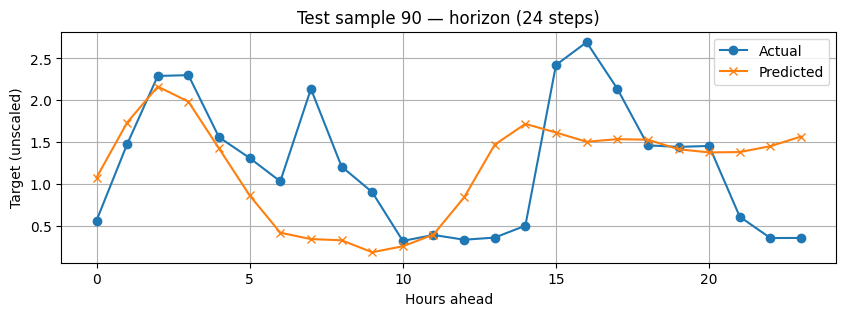

Final test MSE (unscaled, all horizons): 0.396882


In [10]:
# Plot some test samples in first 100 samples comparing predicted vs actual across the horizon
import matplotlib.pyplot as plt
for i in range(0,min(100, preds_un.shape[0]),10):
    plt.figure(figsize=(10, 3))
    plt.plot(range(preds_un.shape[1]), yt_un[i], marker='o', label='Actual')
    plt.plot(range(preds_un.shape[1]), preds_un[i], marker='x', label='Predicted')
    plt.title(f'Test sample {i} — horizon ({preds_un.shape[1]} steps)')
    plt.xlabel('Hours ahead')
    plt.ylabel('Target (unscaled)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Numeric summary (unscaled MSE across all horizons)
mse_unscaled = np.mean((preds_un - yt_un)**2)
print(f'Final test MSE (unscaled, all horizons): {mse_unscaled:.6f}')

Notes:
- This demo uses small epoch counts so it runs quickly; increase epochs for serious training.
- If your DataProcessor used different column ordering or unit scaling, adjust `channel_indices`.

## Cross-Validation Training and Testing

Starting fold 1/5: train (4307, 72, 4) | val (4305, 72, 4)
Epoch 1/20 - train_loss: 0.028842 - val_loss: 0.020409
Epoch 1/20 - train_loss: 0.028842 - val_loss: 0.020409
Epoch 2/20 - train_loss: 0.026444 - val_loss: 0.018804
Epoch 2/20 - train_loss: 0.026444 - val_loss: 0.018804
Epoch 3/20 - train_loss: 0.023692 - val_loss: 0.016009
Epoch 3/20 - train_loss: 0.023692 - val_loss: 0.016009
Epoch 4/20 - train_loss: 0.020523 - val_loss: 0.014846
Epoch 4/20 - train_loss: 0.020523 - val_loss: 0.014846
Epoch 5/20 - train_loss: 0.019071 - val_loss: 0.014534
Epoch 5/20 - train_loss: 0.019071 - val_loss: 0.014534
Epoch 6/20 - train_loss: 0.018335 - val_loss: 0.014296
Epoch 6/20 - train_loss: 0.018335 - val_loss: 0.014296
Epoch 7/20 - train_loss: 0.017746 - val_loss: 0.014200
Epoch 7/20 - train_loss: 0.017746 - val_loss: 0.014200
Epoch 8/20 - train_loss: 0.017140 - val_loss: 0.014100
Epoch 8/20 - train_loss: 0.017140 - val_loss: 0.014100
Epoch 9/20 - train_loss: 0.016666 - val_loss: 0.014004
Epoch 

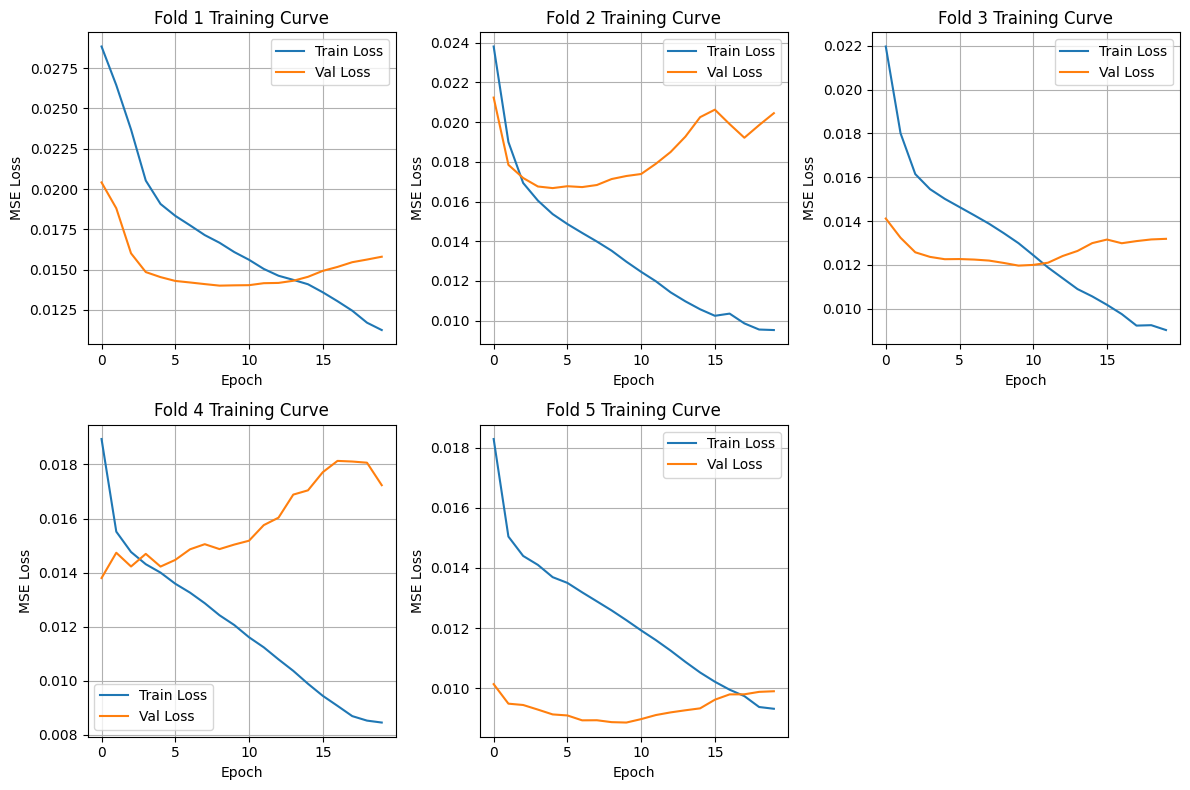

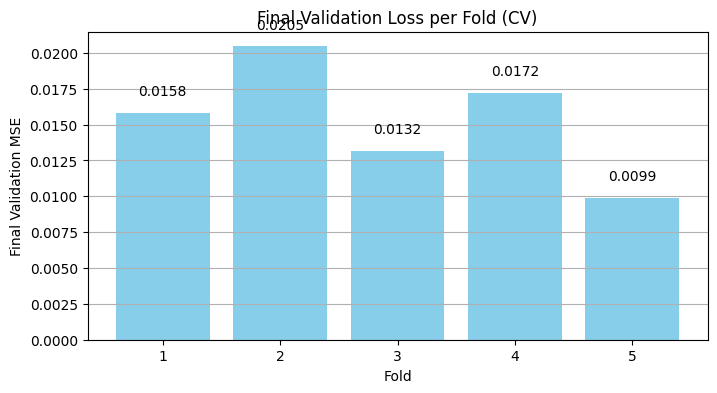

In [11]:
# Final Cross-Validation Training (Higher Epochs)
import numpy as np, torch, matplotlib.pyplot as plt, json, os

# Set final epochs for CV training
FINAL_CV_EPOCHS = 20  # Increase for better training

# Run cross-validation with higher epochs
cv_histories, cv_val_losses, cv_best_checkpoint = cross_validate(
    make_model,
    folds,
    device=None,
    epochs=FINAL_CV_EPOCHS,
    batch_size=32,
    lr=1e-3,
    verbose=True,
    checkpoint_dir='checkpoint/final_cv',
    save_best_only=True
)

print('CV Final val losses per fold:', cv_val_losses)
print('Best CV checkpoint:', cv_best_checkpoint)

# Plot training curves for all folds
plt.figure(figsize=(12, 8))
for i, hist in enumerate(cv_histories, start=1):
    plt.subplot(2, 3, i)
    plt.plot(hist['train_loss'], label='Train Loss')
    if 'val_loss' in hist:
        plt.plot(hist['val_loss'], label='Val Loss')
    plt.title(f'Fold {i} Training Curve')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

# Bar chart of final val losses
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(cv_val_losses) + 1), cv_val_losses, color='skyblue')
plt.xlabel('Fold')
plt.ylabel('Final Validation MSE')
plt.title('Final Validation Loss per Fold (CV)')
plt.xticks(range(1, len(cv_val_losses) + 1))
for i, v in enumerate(cv_val_losses, start=1):
    plt.text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom')
plt.grid(axis='y')
plt.show()

Loaded CV model from checkpoint/final_cv\fold_5\fold5_best.pt


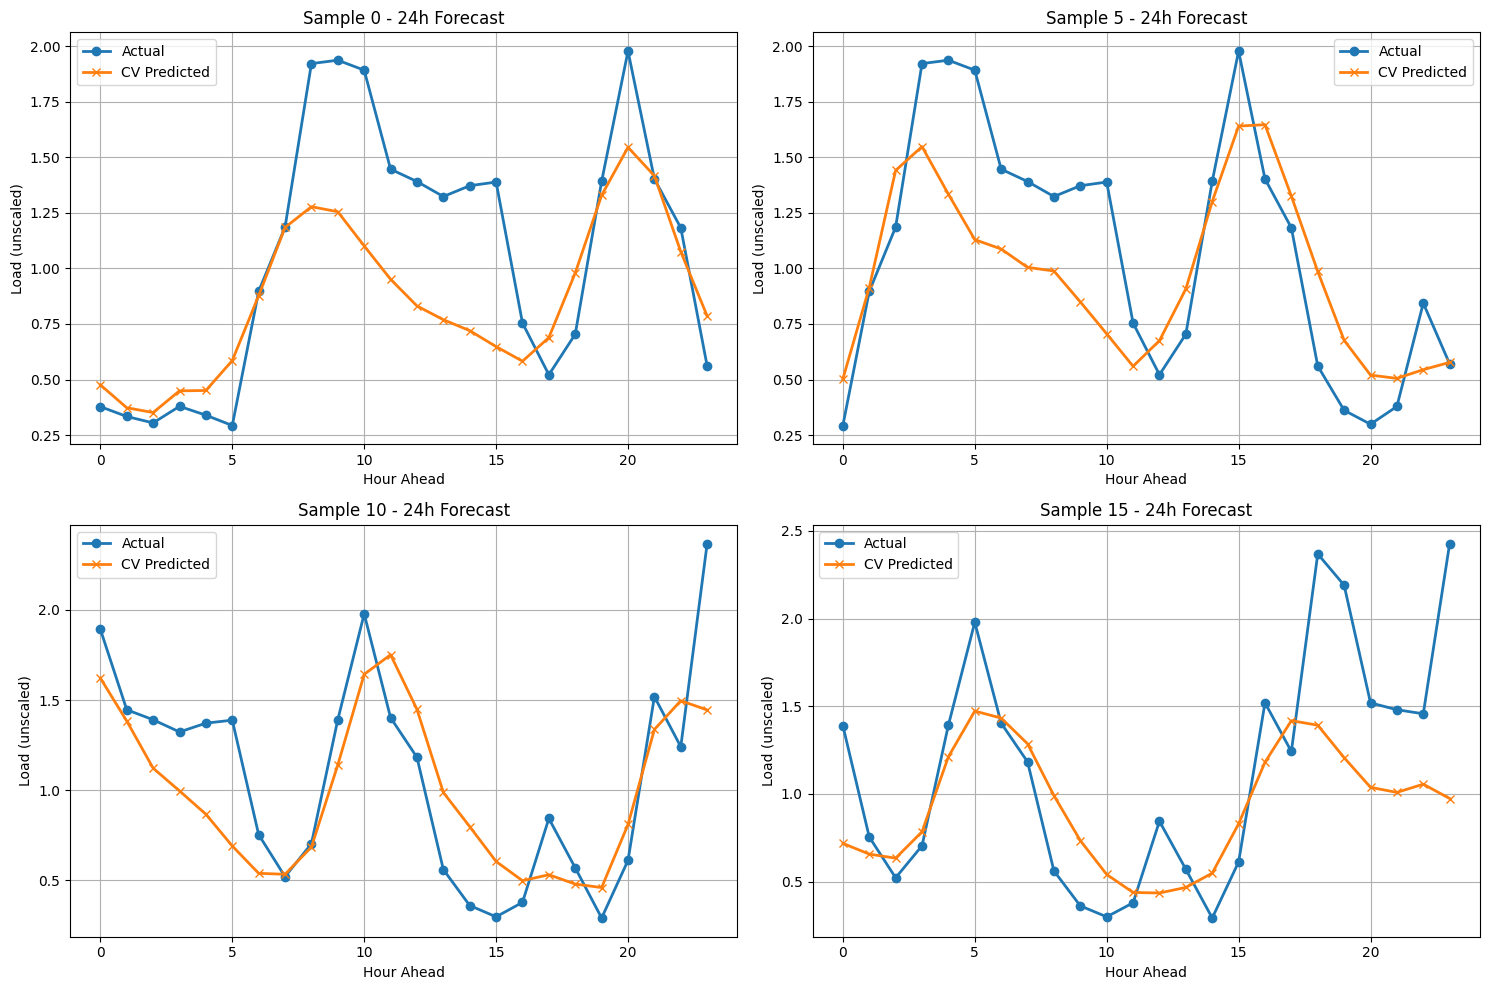

CV Model Test MSE: 0.350639


In [12]:
# Load and Evaluate Best CV Model for Visualization
cv_model = make_model()
if cv_best_checkpoint and os.path.isfile(cv_best_checkpoint):
    ckpt = torch.load(cv_best_checkpoint, map_location='cpu')
    cv_model.load_state_dict(ckpt['model_state_dict'])
    print(f'Loaded CV model from {cv_best_checkpoint}')
else:
    print('CV checkpoint not found')

# Evaluate on test set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cv_model = cv_model.to(device)
cv_model.eval()

with torch.no_grad():
    Xt = torch.tensor(X_test_ch, dtype=torch.float32).to(device)
    if Xt.ndim == 3 and Xt.shape[2] == 4 and Xt.shape[1] != 4:
        Xt = Xt.permute(0, 2, 1)
    cv_preds = cv_model(Xt)
    yt = torch.tensor(y_test, dtype=torch.float32).to(device)
    cv_preds_np = cv_preds.cpu().numpy()
    yt_np = yt.cpu().numpy()

# Inverse transform
cv_preds_un = np.zeros_like(cv_preds_np)
yt_un = np.zeros_like(yt_np)
for t in range(cv_preds_np.shape[1]):
    try:
        cv_preds_un[:, t] = processor.inverse_transform_predictions(cv_preds_np[:, t])
        yt_un[:, t] = processor.inverse_transform_predictions(yt_np[:, t])
    except:
        cv_preds_un[:, t] = cv_preds_np[:, t]
        yt_un[:, t] = yt_np[:, t]

# Sample visualization
sample_indices = [0, 5, 10, 15]  # Choose some samples
plt.figure(figsize=(15, 10))
for idx, sample_idx in enumerate(sample_indices):
    if sample_idx < cv_preds_un.shape[0]:
        plt.subplot(2, 2, idx + 1)
        plt.plot(range(24), yt_un[sample_idx], marker='o', label='Actual', linewidth=2)
        plt.plot(range(24), cv_preds_un[sample_idx], marker='x', label='CV Predicted', linewidth=2)
        plt.title(f'Sample {sample_idx} - 24h Forecast')
        plt.xlabel('Hour Ahead')
        plt.ylabel('Load (unscaled)')
        plt.legend()
        plt.grid(True)
plt.tight_layout()
plt.show()

# Overall MSE
cv_mse = np.mean((cv_preds_un - yt_un)**2)
print(f'CV Model Test MSE: {cv_mse:.6f}')

Loaded Plain model from checkpoint/run1/final_best.pt
Metrics Comparison (Normalized):
CV - MSE: 0.008464, MAE: 0.068729, SMAPE: 0.6105
Plain - MSE: 0.009580, MAE: 0.075414, SMAPE: 0.6353


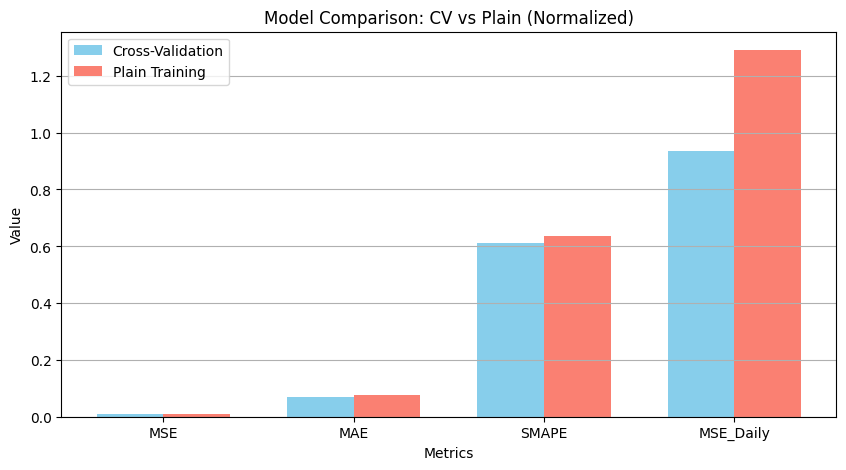

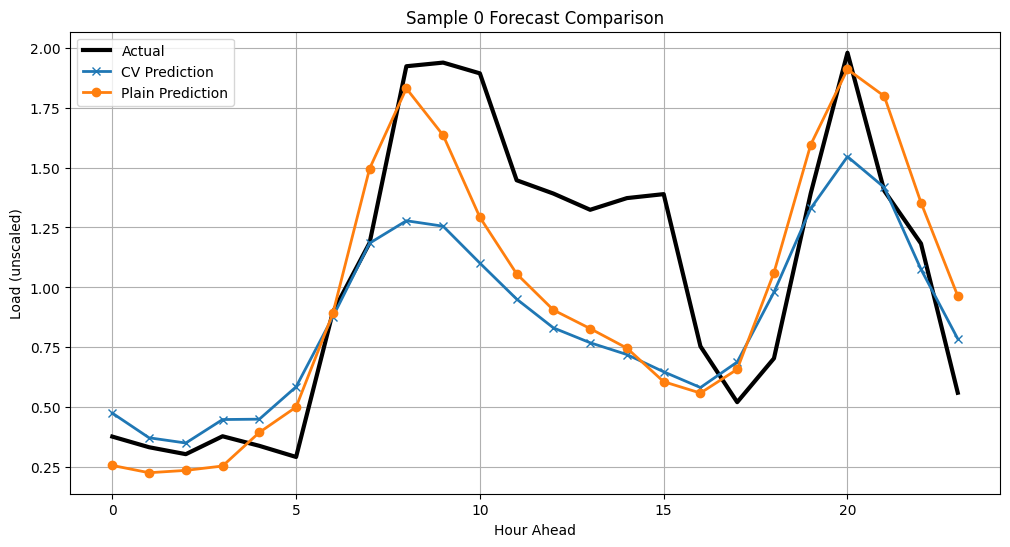

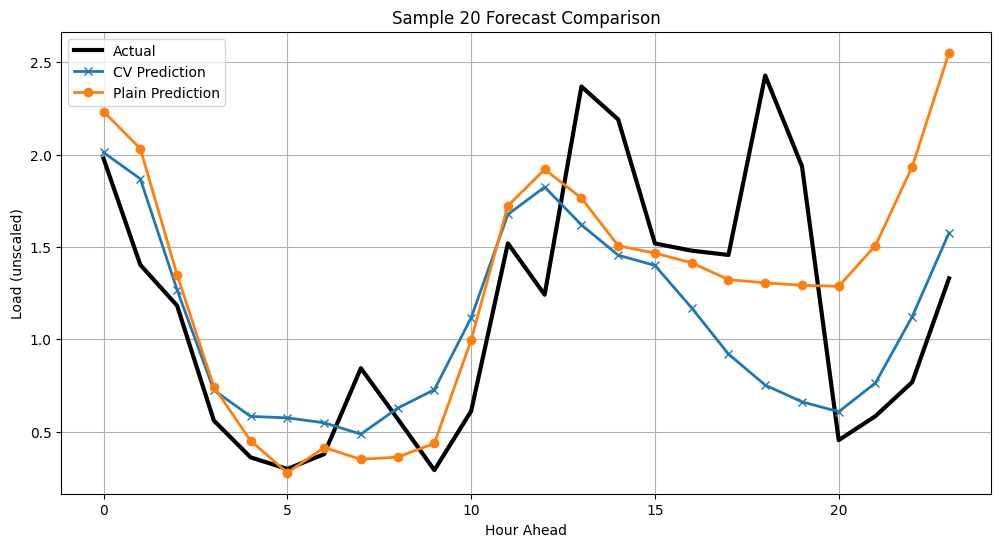

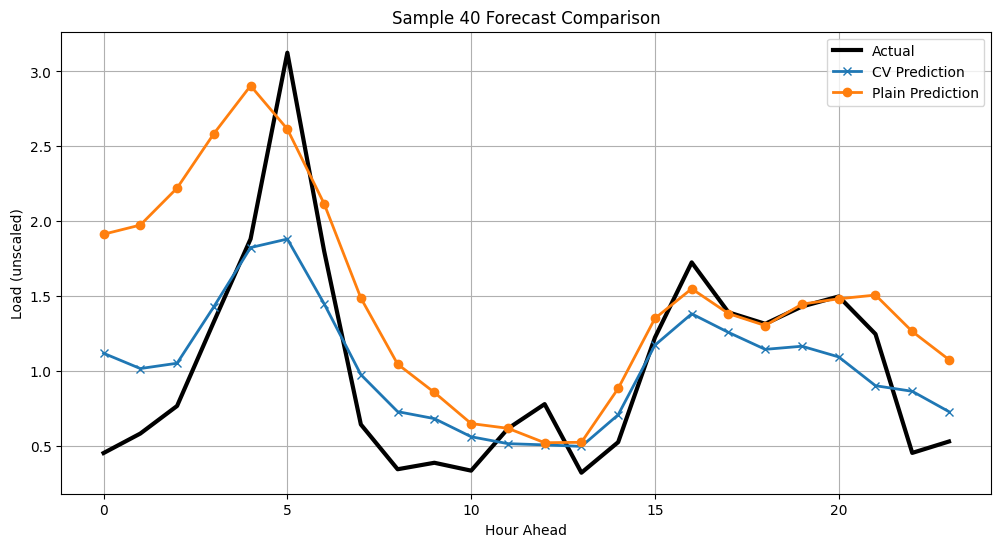

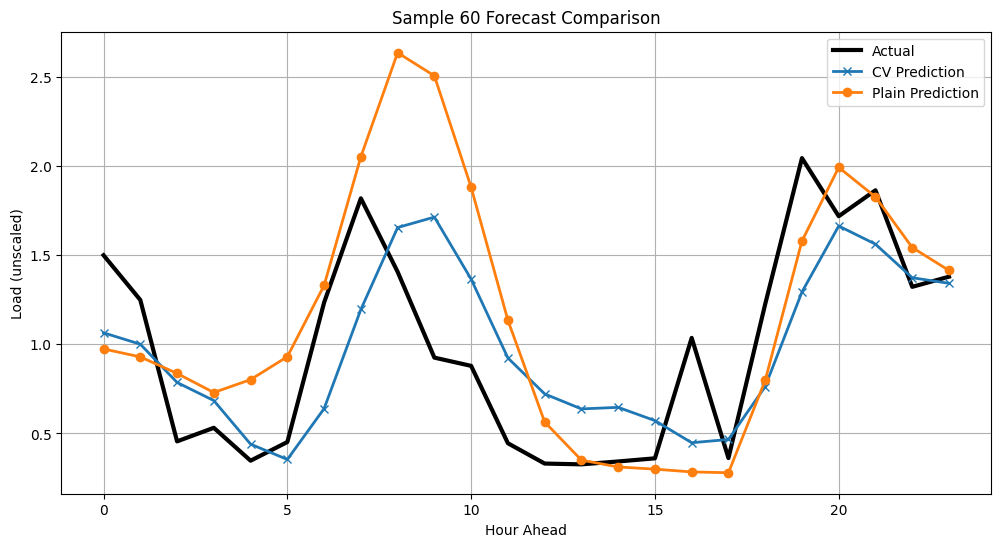

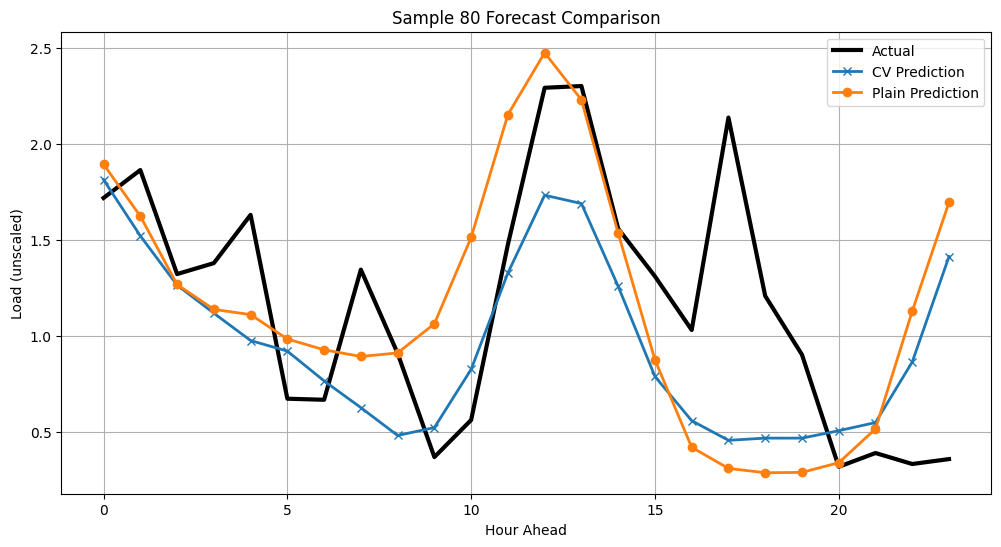

Comparison saved to model_comparison.json


In [15]:
# Comparison Analysis: Plain vs Cross-Validation
import json

# Load Plain model (from earlier training)
plain_checkpoint = 'checkpoint/run1/final_best.pt'  # Assuming this is the path
plain_model = make_model()
if os.path.isfile(plain_checkpoint):
    ckpt = torch.load(plain_checkpoint, map_location='cpu')
    plain_model.load_state_dict(ckpt['model_state_dict'])
    print(f'Loaded Plain model from {plain_checkpoint}')
else:
    print('Plain checkpoint not found')

# Evaluate Plain model
plain_model = plain_model.to(device)
plain_model.eval()
with torch.no_grad():
    plain_preds = plain_model(Xt)  # Xt already defined
    plain_preds_np = plain_preds.cpu().numpy()

# Metrics comparison using normalized (scaled) data
def compute_metrics(preds_scaled, actuals_scaled):
    err = preds_scaled - actuals_scaled
    mse = float(np.mean(err**2))
    mae = float(np.mean(np.abs(err)))
    mape = float(np.mean(np.abs(err) / (np.abs(actuals_scaled) + 1e-8)))
    smape = float(np.mean(2 * np.abs(err) / (np.abs(preds_scaled) + np.abs(actuals_scaled) + 1e-8)))
    daily_sum_err = preds_scaled.sum(axis=1) - actuals_scaled.sum(axis=1)
    mse_daily = float(np.mean(daily_sum_err**2))
    return {'MSE': mse, 'MAE': mae, 'MAPE': mape, 'SMAPE': smape, 'MSE_Daily': mse_daily}

cv_metrics = compute_metrics(cv_preds_np, yt_np)  # Use scaled data
plain_metrics = compute_metrics(plain_preds_np, yt_np)

print('Metrics Comparison (Normalized):')
print(f"CV - MSE: {cv_metrics['MSE']:.6f}, MAE: {cv_metrics['MAE']:.6f}, SMAPE: {cv_metrics['SMAPE']:.4f}")
print(f"Plain - MSE: {plain_metrics['MSE']:.6f}, MAE: {plain_metrics['MAE']:.6f}, SMAPE: {plain_metrics['SMAPE']:.4f}")

# Bar chart comparison
labels = ['MSE', 'MAE', 'SMAPE', 'MSE_Daily']
cv_vals = [cv_metrics['MSE'], cv_metrics['MAE'], cv_metrics['SMAPE'], cv_metrics['MSE_Daily']]
plain_vals = [plain_metrics['MSE'], plain_metrics['MAE'], plain_metrics['SMAPE'], plain_metrics['MSE_Daily']]

x = np.arange(len(labels))
width = 0.35
plt.figure(figsize=(10, 5))
plt.bar(x - width/2, cv_vals, width, label='Cross-Validation', color='skyblue')
plt.bar(x + width/2, plain_vals, width, label='Plain Training', color='salmon')
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Model Comparison: CV vs Plain (Normalized)')
plt.xticks(x, labels)
plt.legend()
plt.grid(axis='y')
plt.show()

# Sample overlay comparison (using unscaled for visualization)
for sample_idx in [0, 20, 40, 60,80]:
    plt.figure(figsize=(12, 6))
    plt.plot(range(24), yt_un[sample_idx], label='Actual', linewidth=3, color='black')
    plt.plot(range(24), cv_preds_un[sample_idx], label='CV Prediction', linewidth=2, marker='x')
    plt.plot(range(24), plain_preds_un[sample_idx], label='Plain Prediction', linewidth=2, marker='o')
    plt.title(f'Sample {sample_idx} Forecast Comparison')
    plt.xlabel('Hour Ahead')
    plt.ylabel('Load (unscaled)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Save comparison results (convert to JSON serializable)
comparison = {
    'cv': cv_metrics,
    'plain': plain_metrics,
    'cv_checkpoint': cv_best_checkpoint,
    'plain_checkpoint': plain_checkpoint
}
with open('model_comparison.json', 'w') as f:
    json.dump(comparison, f, indent=2)
print('Comparison saved to model_comparison.json')